In [60]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [63]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [62]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [64]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [65]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

C:\Users\bouch\AppData\Local\Temp\ipykernel_14096\460333555.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine,reflect=True)


In [66]:
# View all of the classes that automap found
class_names = Base.classes.keys()
class_names

['station', 'measurement']

In [67]:
# Save references to each table
Station=Base.classes.station
Measurement=Base.classes.measurement

In [68]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [69]:
# Find the most recent date in the data set.
most_recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
if most_recent_date:
    most_recent_date = most_recent_date[0]
    most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
most_recent_date

datetime.datetime(2017, 8, 23, 0, 0)

<Figure size 1100x400 with 0 Axes>

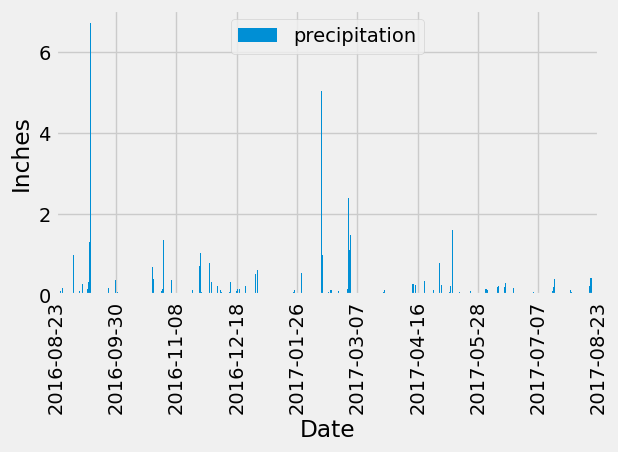

In [70]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
most_recent_date_subquery = session.query(func.max(Measurement.date)).scalar()
most_recent_year = session.query(Measurement).filter(Measurement.date >= func.date(most_recent_date_subquery, '-12 months')).all()
# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= func.date(most_recent_date_subquery, '-12 months')).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_prcp = pd.DataFrame(prcp_scores, columns=['date', 'precipitation'])

# Sort the dataframe by date
df_prcp_sorted = df_prcp.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(11, 4))
df_prcp_sorted.plot(x='date', y='precipitation', kind='bar')
plt.xlabel('Date')
plt.ylabel('Inches')  
num_ticks = 10
tick_positions = np.linspace(0, len(df_prcp_sorted) - 1, num_ticks).astype(int)
plt.xticks(tick_positions, df_prcp_sorted['date'].iloc[tick_positions], rotation=90)
plt.tight_layout()  
plt.show()

In [71]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_stats = df_prcp_sorted['precipitation'].describe()
prcp_table = pd.DataFrame(prcp_stats)
prcp_table.index.name= 'Stats'
prcp_table


,precipitation
Stats,
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [72]:
# Design a query to calculate the total number of stations in the dataset
total_stations=session.query(func.count(Station.station)).scalar()
total_stations

9

In [73]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Station.station, func.count(Measurement.station).label('observation_count')).join(Measurement, Station.station == Measurement.station)
most_active_stations = most_active_stations.group_by(Station.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [74]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id= 'USC00519281'
temperature_stats= session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)). filter(Measurement.station == most_active_station_id).all()
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

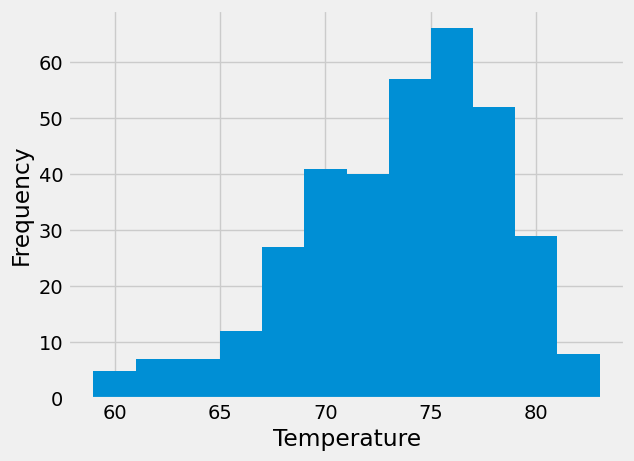

In [75]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

one_year=dt.datetime(most_recent_date.year - 1, most_recent_date.month, most_recent_date.day)
tobs_data=session.query(Measurement.tobs).filter(Measurement.station == most_active_station_id, Measurement.date >= one_year).all()
tobs_df=pd.DataFrame(tobs_data, columns=['tobs'])

plt.hist(tobs_df['tobs'], bins=12)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.show()


# Close Session

In [76]:
# Close Session
session.close()